In [0]:

%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
!pip install py-ecg-detectors
#from ecgdetectors import Detectors


     |████████████████████████████████| 563kB 4.0MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-cp36-none-any.whl size=43806 sha256=a512e05f3d62e60639e3a4e895fd97c3165166ef2e3a3e4e9e05a73cabd98390
  Stored in directory: /root/.cache/pip/wheels/4f/8f/fa/0d7b250ef21828ca373b21f6b3b6ef0f2a0e3560b69c91e55d
Successfully built gatspy


In [0]:
import hrv
help(hrv)

# GLOBAL DECLEARATIONS

In [2]:
import datetime
import os
import random
import statistics as stats
import numpy as np
import scipy.signal as scsig
from scipy.io import loadmat
from scipy.signal import medfilt
import pywt
from pywt import wavedec
from ecgdetectors import Detectors
import hrv
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.ticker as ticker
# dbname_mat folders exist here
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data'
print('GLOBAL DATA DIR :: '+global_dir)

# dbname_npy shoud exsist
global_npydir = os.path.join(global_dir, 'db_npy') #global_dir + 'db_npy/'
print('GLOBAL NPY DIR :: '+global_npydir)

global_datadir = os.path.join(global_npydir, 'data_npy') 
print('GLOBAL DATA DIR :: '+global_datadir)

# global annotation and mapping, common for all ECG from https://physionet.org/about/database/
global_annot = os.path.join(global_dir, 'annotations.txt' )  
print('GLOBAL ANNOTATIONS :: '+global_annot)
# view this file on drive :: https://drive.google.com/open?id=1edhzatX7D3Uo03-d08Lksp807ULlcpgo

#===================================================================================================================
# load MIT annotation mapping  

g_MIT_AMAP_data = np.loadtxt(global_annot, dtype='str',delimiter="\t")
g_MIT_AMAP={}
for a in g_MIT_AMAP_data:
    g_MIT_AMAP[a[0]]= int(a[1])
    #a[0] = orignal mit label (char)
    #a[1] = mapped integer label (int)
    #a[2] = description (str)

map_keys = g_MIT_AMAP.keys()
map_vals = g_MIT_AMAP.values()

print(map_keys)
print(' :: STD LABEL MAPPING :: ')
for k in map_keys:
    print(k+'\t'+str(g_MIT_AMAP[k]))
#print(g_MIT_AMAP)

maxlabels=max(map_vals)+1
print('Max DB Label = '+ str(maxlabels))

g_COLORS = ['green','gold','red']
g_LABELS = np.array(['N','B','A'])
g_COUNT = len(g_LABELS)
print('STD Labels : ' + str(g_LABELS))
print('MAX STD Label = '+ str(g_COUNT))
#===================================================================================================================
print(datetime.datetime.now())
def mapstd(peak_label):
    res = np.zeros(len(peak_label),dtype='int')
    for i in range(0, len(peak_label)):
        res[i] = g_MIT_AMAP[peak_label[i]]
    return res

def print_dict(name, dict_to_print, sep):
    print('\n--> DICT :: '+ str(name))
    for ki in dict_to_print.keys():
        print(str(ki)+sep+str(dict_to_print[ki]))
    print('<------- END')
    return 0
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name

        #self.dirs = db.get_dirs(recname)            # dict              dict of npy data file names to be loaded in data dict used in self.load_data('key')
        self.data = {}                              # dict              dict of npy data file content used in self.read_data('key')

        # find the gain
        self.info = get_minfo(os.path.join(db.dir_mat,recname+'m.hea'))#,db.lead2_index+1)  # head has this info at lead2's index
        self.gain = int(self.info[db.lead2_index+1].split()[2].split('/')[0])
        self.gain5 = int(self.info[db.lead5_index+1].split()[2].split('/')[0])
        #print(self.info)
    
    def print_info(self):
        res = ''
        for i in range(0,len(self.info)):
            res+= self.info[i]
        return res

    def read_data(self, data_type):
        return self.data[data_type] #= np.load(self.dirs[s])

    def load_data(self, data_type):
        self.data[data_type] = np.load(os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy'))
        return self.data[data_type]

#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  sampling_rate, lead2_index, lead5_index):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.srate = sampling_rate #int
        self.lead2_index = lead2_index #int
        self.lead5_index = lead5_index #int
        #self.dir_raw = global_dir + dbname+'_raw/' #str
        self.dir_mat = os.path.join(global_dir , dbname+'_mat') #str
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs = set(np.loadtxt(os.path.join(self.dir_mat,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'MAT DIR :: ' + self.dir_mat )
        print( 'NPY DIR :: ' + self.dir_npy )
        print( 'S_RATE :: ' + str(self.srate))
        print( 'LEAD2 INDEX  :: ' + str(self.lead2_index))
        print( 'LEAD5 INDEX  :: ' + str(self.lead5_index))
        print( 'RECORD SET :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        return 0

    def get_record(self,rec):
        return ecg_record(self,rec)

#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# Pre processing Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  

def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    if res % 2 == 0 : # is even
        res+=1 # make odd
    return res

def filter_signal(X,mfltrs_array):
    X0 = X  #read orignal signal
    for mi in range(0,len(mfltrs_array)):
        X0 = medfilt(X0,mfltrs_array[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

def get_minfo(minfo_path):
    f = open(minfo_path,'r')
    ls = f.readlines()
    f.close()
    #la = ls[minfo_line_index].split()    #I67m.mat 16+192 623/mV 16 0 4441 1894 0 II
    return ls # gain at 2 baseline at 4

#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# Database Building Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 1 Build Annotations :: a.txt -> ant.npy
def build_db_ants(self_db, output_postfix):  
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    #xc=1
    print('\nBEGIN TASK :: Build annotations for ' + str(xs)+ ' records')
    print('REC\tFound\tKnown\tUnknown' )
    for rec in self_db.recs:
        #print('REC: '+rec+ '...'+str(xc)+ ' of '+ str(xs))
        #xc+=1
        ants = np.loadtxt(os.path.join(self_db.dir_mat , rec + 'a.txt'), dtype='str', delimiter= '\n', skiprows = 1)
        #print('\tFound Annotations\t'+str(len(ants)))
        antsnpy = np.zeros((0,2),dtype='str')
        #print('  annotations found '+str(len(ants)))
        for i in range(0,len(ants)):
            a_a = ants[i].split()
            a_sample = a_a[1]
            a_label = a_a[2]
            if (a_label in map_keys):
                antsnpy = np.vstack((antsnpy,np.array([a_sample,a_label]))) # sample,label str
            else:
                print('\tWARNING :: Unknown annotation "'+a_label+'" found at [' +a_sample+ '] in file a.txt, skipping....')
        
        adf =  len(ants) - len(antsnpy) 
        #print('\tKnown Annotations\t'+str(len(antsnpy)))
        # print('\tUnknown Annotations\t'+str(adf))
        print(rec + '\t'+ str(len(ants)) + '\t'+str(len(antsnpy))+'\t' + str(adf) )
        # save for this record
        np.save(os.path.join(self_db.dir_npy , rec+ '_'+output_postfix+'.npy'), antsnpy)
        #print('\tSaved at "'+save_loc+'"')
    print('\nEND TASK :: Build annotations for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 3 Extract Raw lead2 signal :: m.mat[lead2] -> raw2.npy
def build_db_signal(self_db, output_postfix, lead_indices):  # saves xm.mat[lead2] --> x_raw2.npy
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    print('\nBEGIN TASK :: Save signal data for ' + str(xs)+ ' records')
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        mat_signal = loadmat(os.path.join( self_db.dir_mat , rec + 'm.mat'))['val']#[self_db.lead2_index]
        for li in range(0,len(lead_indices)):
            np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix[li]+'.npy'), mat_signal[lead_indices[li]])    
    print('END TASK :: Save signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 4 Filter Raw/Denoised signal :: raw2.npy -> med2.npy or den2.npy -> rmd2.npy
def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix): 
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    mfa = np.zeros(len(ms_flt_array), dtype='int')
    #print('fun')
    for i in range(0, len(ms_flt_array)):
        mfa[i] = get_median_filter_width(self_db.srate,ms_flt_array[i])
        #print('loop')
    print('\nBEGIN TASK :: filer signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy')) #np.save(rec_fnpy + '_raw2.npy', mat_signal) 
        X_med2 = filter_signal(X, mfa)
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_med2) # save a copy of (median filtered ) signal = r,m  
        #----------------------------------------------------------------------         
    print('END TASK :: filer signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 5 Denoise Raw/Filtered signal :: med2.npy -> rdm2.npy or raw2.npy -> den2.npy
def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    
    print('\nBEGIN TASK :: denoising signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy') ) # np.load(self_db.dir_npy + rec + '_raw2.npy')
        X_rlt2 = denoise_signal(X,dwt_transform, dlevels, cutoff_low, cutoff_high )
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_rlt2) # save a copy of (only denoised)  signal = r,m,d 
        #----------------------------------------------------------------------         
    print('END TASK :: denoising signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------


GLOBAL DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_npy
GLOBAL ANNOTATIONS :: /content/drive/My Drive/Masters/workdir/ecg_data/annotations.txt
dict_keys(['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?', '[', '!', ']', 'x', '(', ')', 'p', 't', 'u', '`', "'", '^', '|', '~', '+', 's', 'T', '*', 'D', '=', '"', '@'])
 :: STD LABEL MAPPING :: 
N	0
L	1
R	1
B	1
A	2
a	2
J	2
S	2
V	2
r	2
F	2
e	2
j	2
n	2
E	2
/	-1
f	-1
Q	2
?	-1
[	-2
!	2
]	-2
x	-2
(	-2
)	-2
p	-2
t	-2
u	-2
`	-2
'	-2
^	-2
|	-2
~	-2
+	-2
s	-2
T	-2
*	-2
D	-2
=	-2
"	-2
@	-2
Max DB Label = 3
STD Labels : ['N' 'B' 'A']
MAX STD Label = 3
2020-03-04 22:57:20.092301


# DB DICT CREATION

In [3]:
# def __init__(self, dbname,  sampling_rate, lead2_index):
all_db = {}
all_db['mitdb'] = ecg_db('mitdb', 360, 0, 1 )
all_db['svdb'] = ecg_db('svdb',  128, 0, 1)
all_db['incartdb'] = ecg_db('incartdb', 257, 1, 10)
#print(all_db.values())
print('')
print(all_db.keys())


g_ANT_POSTFIX = 'ant'
g_RAW2_POSTFIX = 'raw2'
g_RAW5_POSTFIX = 'raw5'
g_MED2_POSTFIX = 'med2'
g_MED5_POSTFIX = 'med5'
g_DEN_POSTFIX = 'den2'
g_RMD_POSTFIX = 'rmd2'
g_RDM_POSTFIX = 'rdm2'





Initailze new ecg database ... 
DB NAME :: mitdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/mitdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
S_RATE :: 360
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [48] {'203', '233', '215', '200', '103', '123', '214', '208', '101', '115', '117', '231', '205', '118', '230', '222', '100', '122', '119', '213', '228', '121', '106', '221', '113', '104', '107', '105', '209', '210', '116', '223', '232', '202', '201', '114', '220', '102', '111', '234', '217', '112', '124', '108', '207', '219', '109', '212'}

Initailze new ecg database ... 
DB NAME :: svdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/svdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
S_RATE :: 128
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [78] {'858', '861', '871', '820', '808', '887', '803', '807', '810', '843', '876', '885', '812', '827', '842', '867', '873', '892', '893', 

# [ DATA EXTRACTION ]

In [0]:
#    C A R E F U L   D O N T     R U N    T H I S 


db_data = all_db.values()
# input output postfix = _[postfix].npy
print(datetime.datetime.now())
print('S T A R T \n')

for db in db_data:
#=========================================================================================
    print ('\n START ON DATABASE: '+ db.name +' \t'+ str(datetime.datetime.now()))
    
    #try: 
    #    directory = os.makedirs(os.path.join(global_npydir, db.name+'_npy') , exist_ok = True) 
    #    print("Directory '%s' created successfully" % directory) 
    #except OSError as error: 
     #   print("Directory '%s' can not be created" % directory) 
#=========================================================================================

    #print ('\n START COPY ANNOTATIONS \t'+ str(datetime.datetime.now()))
    #build_db_ants(db, g_ANT_POSTFIX) # build_db_ants(self, output_postfix)

#=========================================================================================

    #print ('\n START MAP ANNOTATIONS \t'+ str(datetime.datetime.now()))
    #map_db_ants(db, g_MIT_AMAP,g_ANT_POSTFIX,g_MIT_AMAP_POSTFIX) #map_db_ants(self, g_map, input_postfix, output_postfix)

#=========================================================================================

    print ('\n START EXTRACTING RAW SIGNAL [ R ] \t'+ str(datetime.datetime.now()))
    build_db_signal(db, [g_RAW5_POSTFIX],[db.lead5_index]) # build_db_signal(self, output_postfix)
    #build_db_signal(db, [g_RAW2_POSTFIX],[db.lead2_index]) # build_db_signal(self, output_postfix)

#=========================================================================================

    print ('\n START FILTERING RAW SIGNAL [ R M ] \t'+ str(datetime.datetime.now()))
    #print('this')
    filter_db_signal(db, [0.2,0.6],g_RAW5_POSTFIX,g_MED5_POSTFIX) # filter_db_signal(self, ms_flt_array, input_postfix, output_postfix)
    #print ('\n START DENOISE FILTERED SIGNAL [ R M D ] \t'+ str(datetime.datetime.now()))
    #denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_MED_POSTFIX, g_RMD_POSTFIX ) # denoise_db_signal(self, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):

#=========================================================================================

    #print ('\n START DENOISE RAW SIGNAL [ R D ]\t'+ str(datetime.datetime.now()))
    #denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_RAW_POSTFIX, g_DEN_POSTFIX ) # denoise_db_signal(self, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
    #print ('\n START FILTERING DENOISE SIGNAL [ R D M ] \t'+ str(datetime.datetime.now()))
    #filter_db_signal(db, [0.2,0.6],g_DEN_POSTFIX, g_RDM_POSTFIX) # filter_db_signal(self, ms_flt_array, input_postfix, output_postfix)
#=========================================================================================
    print ('\n END ON DATABASE:'+ db.name +' \t'+ str(datetime.datetime.now()))
#=========================================================================================
print('\n E N D ')
print(datetime.datetime.now())
#    C A R E F U L   D O N T     R U N    T H I S 

# A : VIEW Section





# :: PlOT FIG 3-min (180 sec) SIGNAL


In [0]:

base_png_dir = '/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_png/'

idbs = 'svdb'  # 'mitdb'  'svdb' 'incartdb'
irec = '800'

dbs = all_db[idbs]
selrec = dbs.get_record(irec)
manual_gain=1/selrec.gain

os.makedirs(base_png_dir+selrec.name,exist_ok=True)
logt = open(base_png_dir+selrec.name+'/log.txt','w')
logt.write(selrec.print_info())
logt.write('\n======================\n======================\n')

selrec.load_data(g_ANT_POSTFIX)   
#selrec.load_data(g_MIT_AMAP_POSTFIX)
selrec.load_data(g_MED5_POSTFIX)
selrec.load_data(g_MED2_POSTFIX)
# extract annotations ==================================================================================
ant2 = selrec.read_data(g_ANT_POSTFIX)       # all annotations
#ant2m = selrec.read_data(g_MIT_AMAP_POSTFIX) # only has mapr>=0 {no umapped beats preset}

ant_s = ant2[:,0].astype('int')
ant_l = ant2[:,1]

#ant_sm = ant2m[:,0]
#ant_lm = ant2m[:,1]
#=================================================
ff = 0 #figure
med2 = np.multiply(selrec.read_data(g_MED2_POSTFIX), [manual_gain])
med5 = np.multiply(selrec.read_data(g_MED5_POSTFIX), [manual_gain])
meds = [med2, med5]
L = len(med2)
Lsec = L / selrec.db.srate #1800 secs

Lone = 180 #sec
Lmax = int(Lsec / Lone)
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================



time_pad = 3 #secs
# extract annotations ==================================================================================
for ii in range(0,Lmax):
    fj = Lone*ii 
    tj = fj + Lone

    fi = fj - time_pad
    ti = tj + time_pad

    fii = fi*selrec.db.srate
    tii = ti*selrec.db.srate

    ri_f = 0
    ri_t = 0
    if fii<0:
        ri_f = -fii
        fii = 0
    if tii>L:
        ri_t =  tii - L 
        tii=L

    ant2x = ant2[(ant_s>=fii) & (ant_s<tii)]
    ant_sx = ant2x[:,0].astype('int')
    ant_lx = ant2x[:,1]
    mm = mapstd(ant_lx)
    med2X = np.arange(fi,ti,1/selrec.db.srate)
    tdict ={}
    for mk in range(0,len(ant_lx)):
        if ant_lx[mk] in tdict:
            tdict[ant_lx[mk]]+=1
        else:
            tdict[ant_lx[mk]]=1

    logt.write(selrec.name + ' [Duration] = '+ str(fj)+':'+str(tj)+' : '+str(tdict))
    logt.write('\n======================\n======================\n')
    # plot record annotations ==================================================================================
    for mx in range (0,len(meds)):
        plt.figure(ff, figsize=(250,4),dpi=100)
        ff+=1
        plt.ylim(-2.5, 2.5 )
        plt.xlim(fi , ti  )
        aa = plt.axes()
        ax = aa.get_xaxis()
        ay = aa.get_yaxis()
        ax.set_major_locator(ticker.MultipleLocator(5))
        ay.set_visible(False)
        plt.grid(axis='x' )

        jt = np.hstack( ( np.zeros(ri_f),meds[mx][fii:tii],np.zeros (ri_t) )) #med2[fii-selrec.db.srate*5:fii]
        plt.plot(med2X,jt,linewidth='0.2', color='black')
        plt.title(selrec.name + ' [Duration] = '+ str(fj)+':'+str(tj))
        ant_sxm = np.multiply(ant_sx,[1/selrec.db.srate])
        #plt.xticks(ant_sxm,ant_lx)

        #scatter all of them
        
    
        #------------------------------ NON BEAT ANOTATIONS HERE ------------------------------
        
        for mk in range(0,len(ant_lx)):
            mmp=mm[mk]
            col = 'black'
            ycord = -1.5
            if mmp >=0 :
                col = g_COLORS[mmp]
                ycord= -2
            plt.annotate( ant_lx[mk], xy= ( ant_sxm[mk],ycord) , color=col)

        
        #plt.legend()
        plt.savefig(base_png_dir+selrec.name +'/'+selrec.name+'_'+ str(fj)+'_'+str(tj)+'_' +str(mx)+'.png',bbox_inches='tight')
        plt.close()
        #break

logt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

# :: EXP : Filtering and peak detection


incartdb
I10
incartdb_I10
incartdb_I10 [Duration] = 0:10 : {'N': 26}


mdis = 77
mwid1 = 2.57
mwid2 = 51.400000000000006

-----------------------------------
R PEAKS 26
[123, 236, 375, 503, 631, 743, 868, 1007, 1135, 1262, 1364, 1495, 1623, 1760, 1863, 2007, 2135, 2246, 2384, 2497, 2596, 2722, 2848, 2967, 3113, 3226]

-----------------------------------

-----------------------------------
R PEAKS 26
[123, 234, 376, 488, 630, 755, 884, 1003, 1121, 1260, 1382, 1500, 1637, 1747, 1885, 2009, 2133, 2238, 2386, 2506, 2603, 2722, 2845, 2984, 3112, 3225]

-----------------------------------
incartdb_I10 [Duration] = 10:20 : {'N': 33}


mdis = 77
mwid1 = 2.57
mwid2 = 51.400000000000006


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi


-----------------------------------
R PEAKS 32
[85, 208, 336, 447, 563, 698, 797, 923, 1049, 1168, 1314, 1427, 1548, 1683, 1825, 1940, 2084, 2198, 2326, 2453, 2595, 2710, 2835, 2962, 3089, 3230, 3343, 3470, 3611, 3738, 3865, 3994]

-----------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi


-----------------------------------
R PEAKS 33
[86, 210, 334, 439, 587, 707, 804, 923, 1046, 1185, 1313, 1426, 1572, 1682, 1826, 1939, 2068, 2214, 2341, 2470, 2580, 2723, 2846, 2976, 3106, 3228, 3359, 3469, 3611, 3722, 3866, 3995, 4104]

-----------------------------------
incartdb_I10 [Duration] = 20:30 : {'N': 33}


mdis = 77
mwid1 = 2.57
mwid2 = 51.400000000000006

-----------------------------------
R PEAKS 31
[83, 265, 392, 519, 660, 773, 900, 1041, 1168, 1295, 1424, 1549, 1677, 1804, 1930, 2044, 2170, 2297, 2439, 2554, 2680, 2820, 2937, 3081, 3209, 3334, 3466, 3583, 3712, 3853, 3968]

-----------------------------------

-----------------------------------
R PEAKS 32
[86, 276, 406, 536, 658, 789, 899, 1041, 1152, 1296, 1425, 1534, 1663, 1804, 1928, 2060, 2185, 2311, 2425, 2553, 2693, 2819, 2951, 3083, 3207, 3332, 3469, 3598, 3712, 3848, 3959, 4096]

-----------------------------------
incartdb_I10 [Duration] = 30:40 : {'N': 32}


mdis = 77
mwid1 = 2.57
mwid2 = 51.400000000000006

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



-----------------------------------
R PEAKS 32
[84, 229, 381, 513, 637, 762, 899, 1028, 1142, 1278, 1389, 1526, 1668, 1783, 1922, 2053, 2182, 2306, 2439, 2560, 2693, 2823, 2932, 3059, 3204, 3332, 3441, 3567, 3693, 3838, 3965, 4092]

-----------------------------------


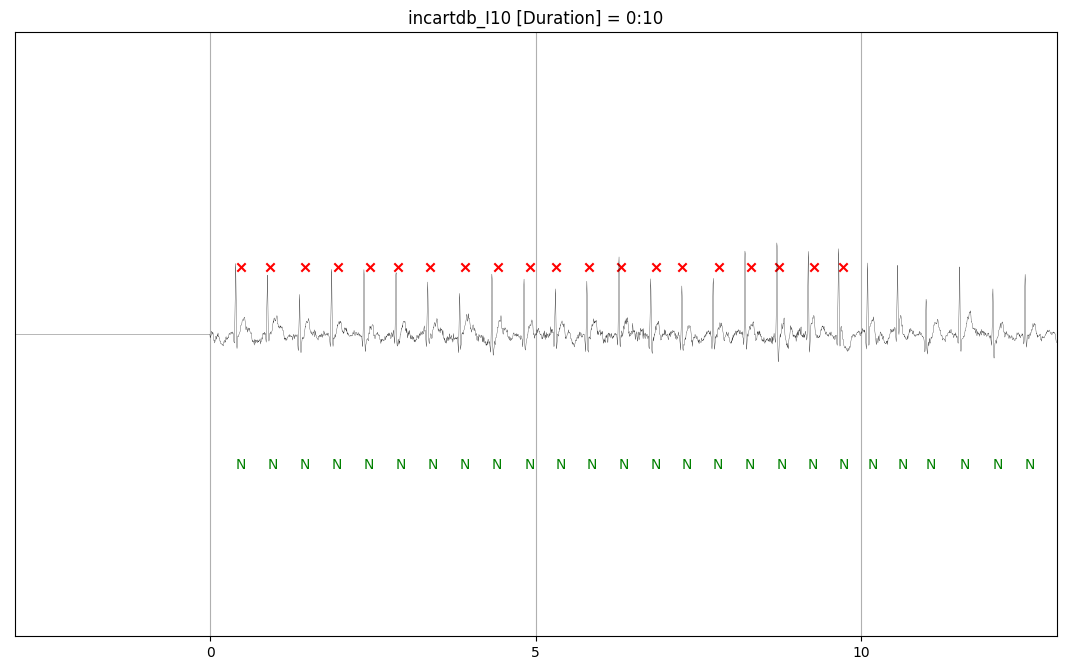

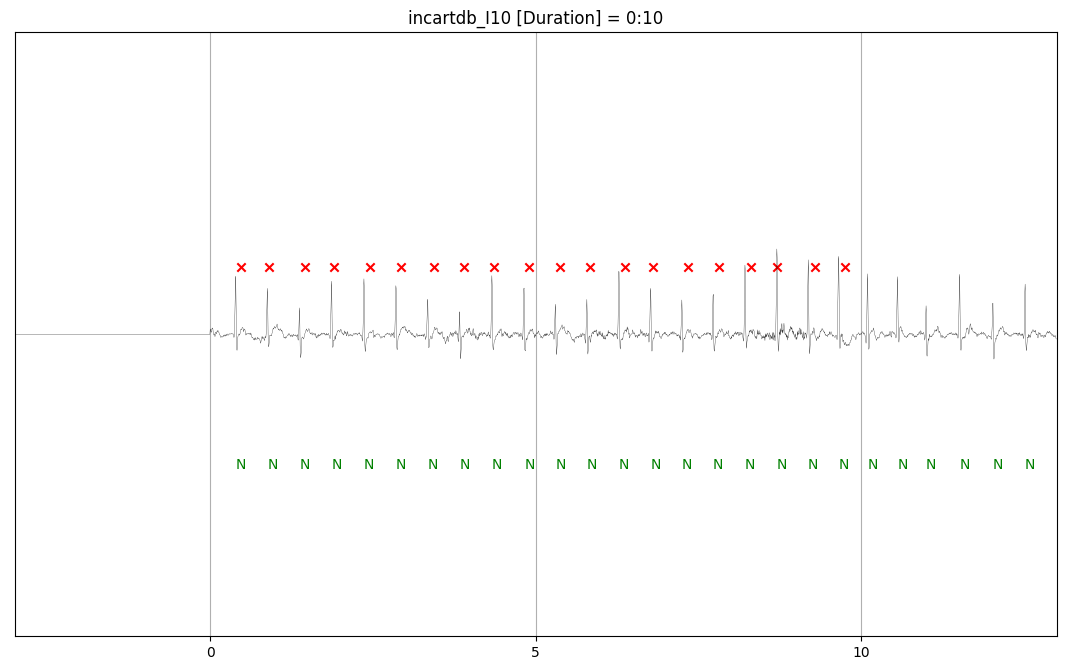

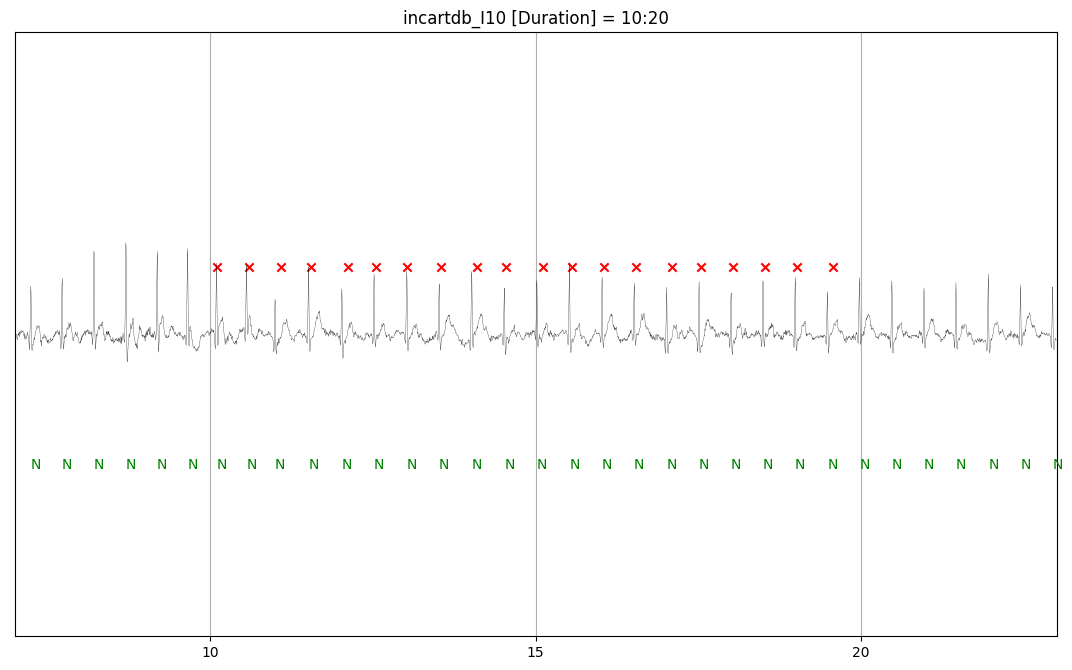

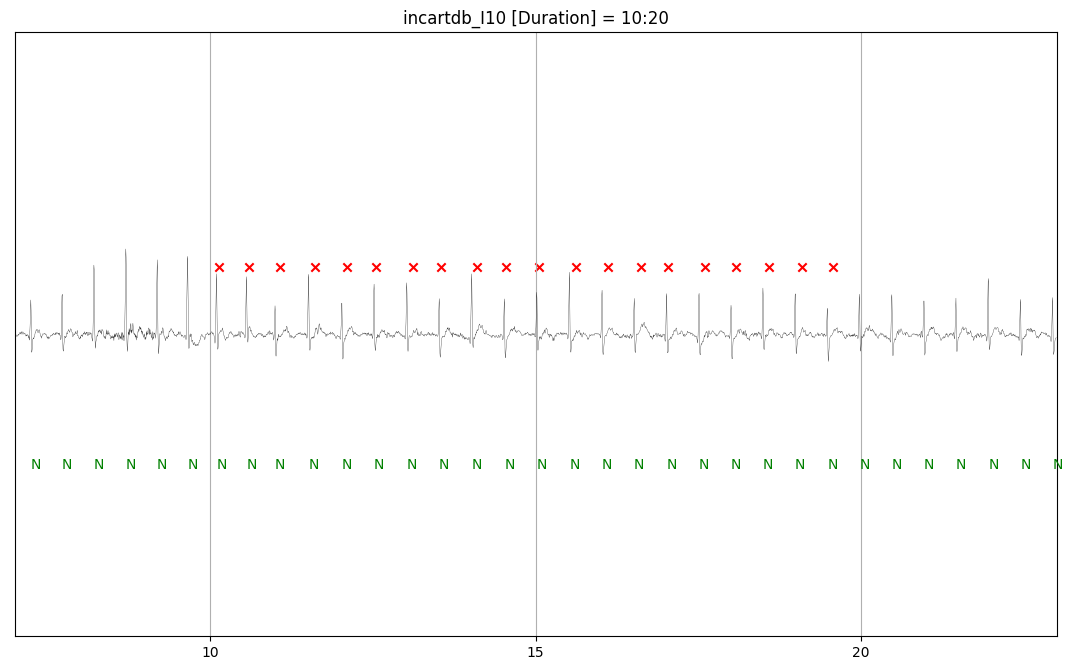

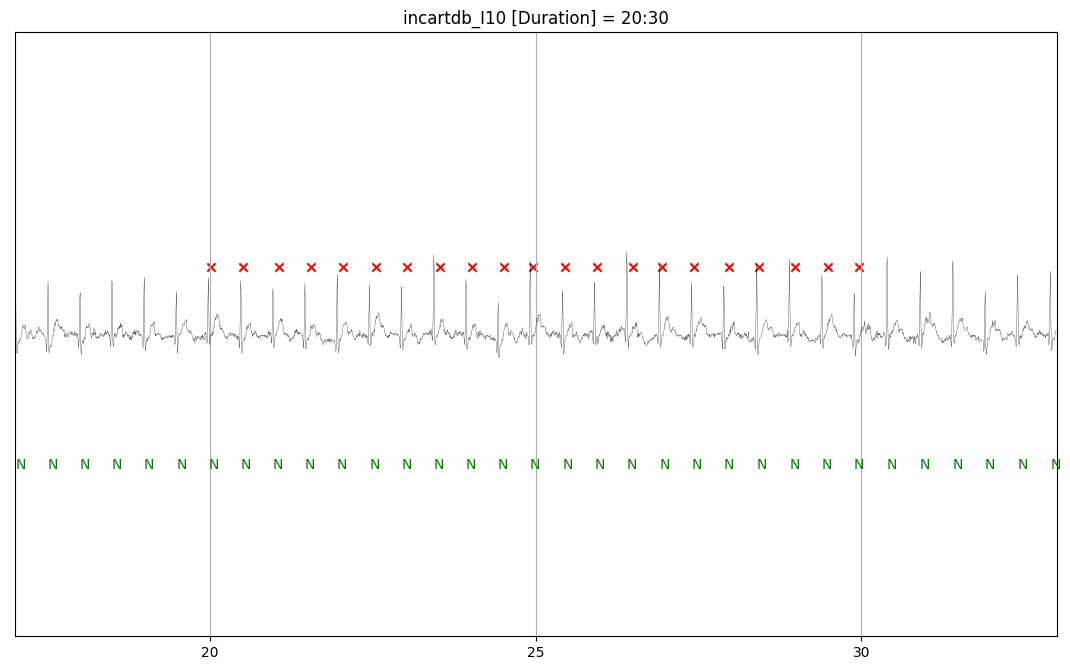

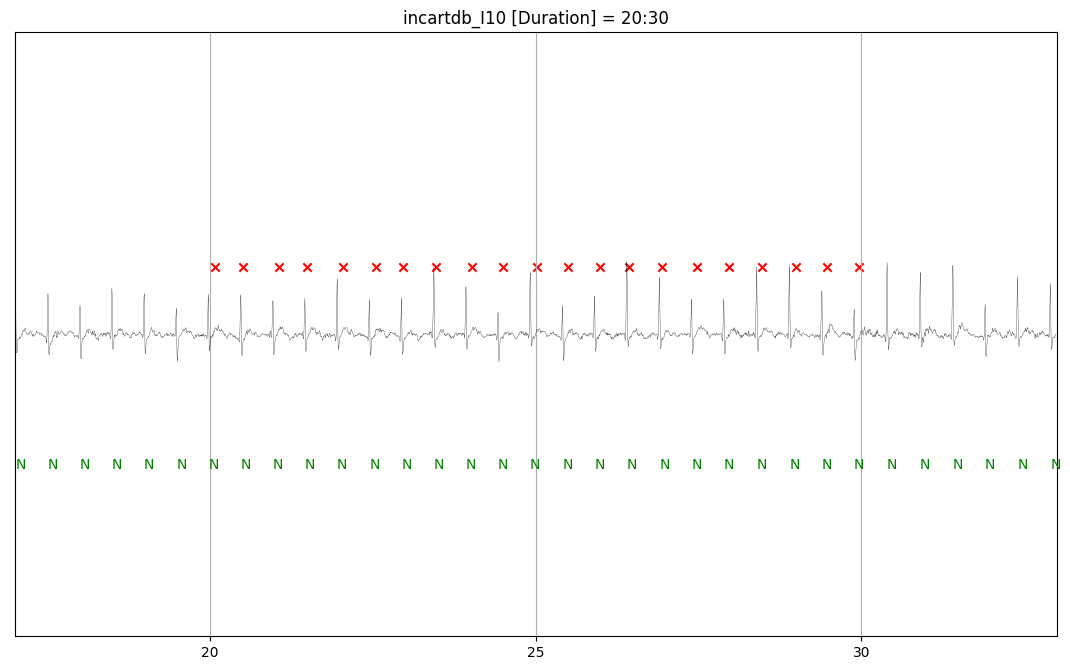

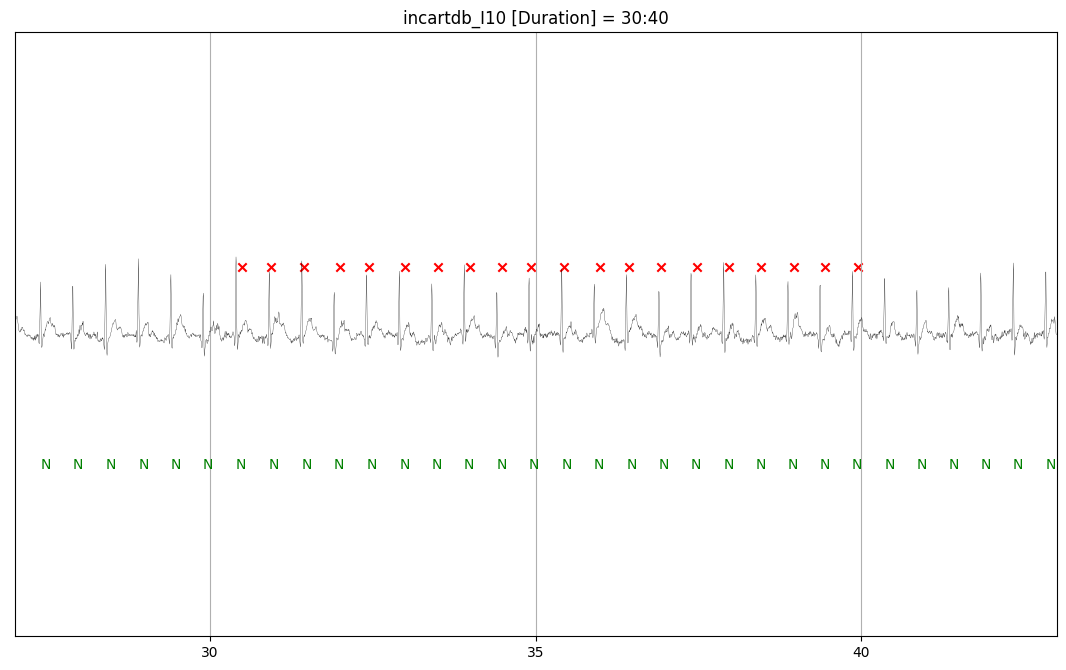

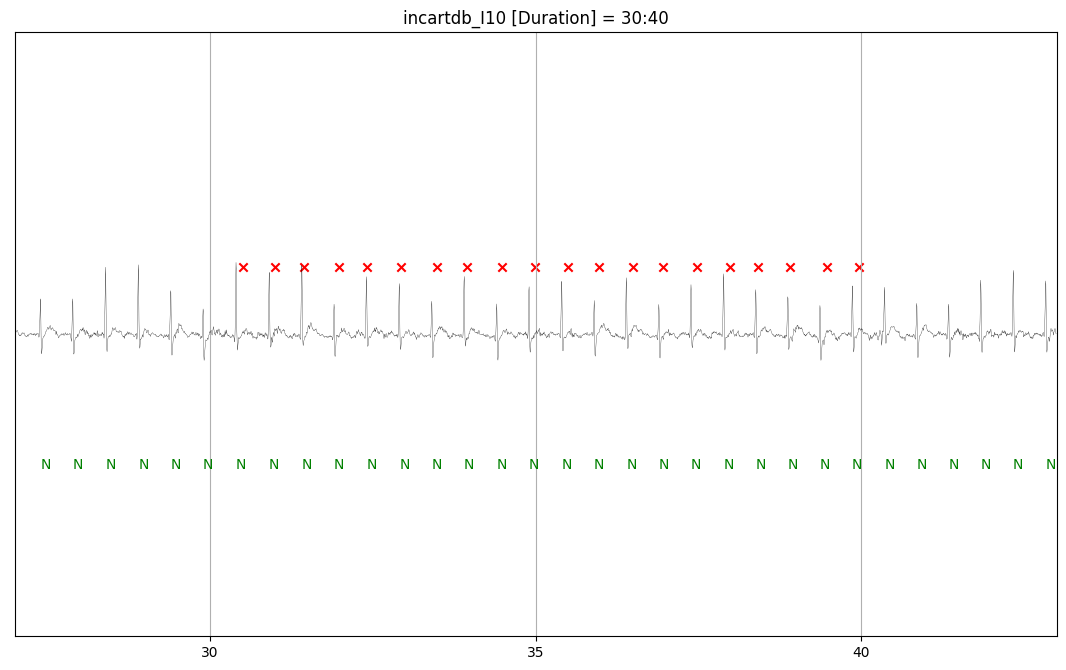

In [0]:

base_png_dir = '/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_png/'
randdb = ['mitdb' , 'svdb', 'incartdb']
idbs = randdb[random.randint(0,2)]#'mitdb'  # 'mitdb'  'svdb' 'incartdb'
print(idbs)
dbs = all_db[idbs]
reclist = list(dbs.recs)
irec = reclist[random.randint(0,len(reclist)-1)] #'219'
print(irec)

selrec = dbs.get_record(irec)
manual_gain=1/selrec.gain
print(selrec.name)
#os.makedirs(base_png_dir+selrec.name,exist_ok=True)
#logt = open(base_png_dir+selrec.name+'/log.txt','w')
#logt.write(selrec.print_info())
#logt.write('\n======================\n======================\n')

selrec.load_data(g_ANT_POSTFIX)   
#selrec.load_data(g_MIT_AMAP_POSTFIX)
selrec.load_data(g_MED5_POSTFIX)
selrec.load_data(g_MED2_POSTFIX)
# extract annotations ==================================================================================
ant2 = selrec.read_data(g_ANT_POSTFIX)       # all annotations
#ant2m = selrec.read_data(g_MIT_AMAP_POSTFIX) # only has mapr>=0 {no umapped beats preset}

ant_s = ant2[:,0].astype('int')
ant_l = ant2[:,1]

#ant_sm = ant2m[:,0]
#ant_lm = ant2m[:,1]
#=================================================
ff = 0 #figure
med2 = np.multiply(selrec.read_data(g_MED2_POSTFIX), [manual_gain])
med5 = np.multiply(selrec.read_data(g_MED5_POSTFIX), [manual_gain])
meds = [med2, med5]
L = len(med2)
Lsec = L / selrec.db.srate #1800 secs

Lone = 10 #sec
Lmax = 4#int(Lsec / Lone)
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================


detectors = Detectors(selrec.db.srate)
time_pad = 3 #secs
# extract annotations ==================================================================================
for ii in range(0,Lmax):
    fj = Lone*ii 
    tj = fj + Lone

    fjj = fj*selrec.db.srate
    tjj = tj*selrec.db.srate

    fi = fj - time_pad
    ti = tj + time_pad

    fii = fi*selrec.db.srate
    tii = ti*selrec.db.srate

    ri_f = 0
    ri_t = 0
    if fii<0:
        ri_f = -fii
        fii = 0
    if tii>L:
        ri_t =  tii - L 
        tii=L

    ant2x = ant2[(ant_s>=fii) & (ant_s<tii)]
    ant_sx = ant2x[:,0].astype('int')
    ant_lx = ant2x[:,1]
    mm = mapstd(ant_lx)
    med2X = np.arange(fi,ti,1/selrec.db.srate)
    tdict ={}
    for mk in range(0,len(ant_lx)):
        if ant_lx[mk] in tdict:
            tdict[ant_lx[mk]]+=1
        else:
            tdict[ant_lx[mk]]=1

    print(selrec.name + ' [Duration] = '+ str(fj)+':'+str(tj)+' : '+str(tdict))
    print('\n======================\n======================\n')
    # plot record annotations ==================================================================================
    mdis = int((selrec.db.srate * 60) / 200)  # maximum 320 bpm
    mwid1 = selrec.db.srate * 0.01
    mwid2 = selrec.db.srate * 0.20
    print('mdis = '+ str(mdis))
    print('mwid1 = '+ str(mwid1))
    print('mwid2 = '+ str(mwid2))
    for mx in range (0,len(meds)):
        plt.figure(ff, figsize=( (250/186)*Lone, 8 )  ,dpi=100)
        ff+=1
        plt.ylim(-4.5, 4.5 )
        plt.xlim(fi , ti  )
        aa = plt.axes()
        ax = aa.get_xaxis()
        ay = aa.get_yaxis()
        ax.set_major_locator(ticker.MultipleLocator(5))
        ay.set_visible(False)
        plt.grid(axis='x' )

        imed = meds[mx][fii:tii]
        #differenciate
        #qrsf = scsig.firwin(3*selrec.db.srate, [5, 15], pass_zero=False, fs=selrec.db.srate)
        #imedf = scsig.filtfilt(qrsf,a=1,x=imed)
        r_peaks = detectors.pan_tompkins_detector(  unfiltered_ecg = imed)
        #print (r_peaks)
        #mwid = int(selrec.db.srate * 0.012)  # width of 0.12 sec
        #pks , pdict = scsig.find_peaks( imed , prominence=0.4 , distance = mdis)#, width =  [mwid1,mwid2])   # , prominence=1 , distance = mdis
        #pks1 , pdict1 = scsig.find_peaks(np.multiply(imed,[-1]) ,prominence=0.4 , distance = mdis)#, width = [mwid1,mwid2])   # , prominence=1 , distance = mdis
        #pks = scsig.find_peaks_cwt(imed,mwid)
        #print(pks)
        print('\n-----------------------------------')
        #print(str(mx))
        #print ('+Peaks')
        #print (pdict)
        #print (pdict['prominences'])
        #print (pdict['width_heights'])
        #print (pdict['widths'])
        #print ('-Peaks')
        #print (pdict1)
        #print (pdict1['prominences'])
        #print (pdict1['width_heights'])
        #print (pdict1['widths'])

        #pks = np.add(pks,[fii])
        #pks1 = np.add(pks1,[fii])
       # pksf = np.unique(np.hstack((pks,pks1)))
        #print ('MAX PEAKS '+str(len(pks))+'\n'+str(pks))
        print ('R PEAKS '+str(len(r_peaks))+'\n'+str(r_peaks))
        print('\n-----------------------------------')
        #medpks = np.multiply(np.add(pks,[fii]),[1/selrec.db.srate])
        #medpks1 = np.multiply(np.add(pks1,[fii]),[1/selrec.db.srate])
        
        rpeaks = np.array(r_peaks)
        rpeaks = np.multiply(np.add(rpeaks,[fii]),[1/selrec.db.srate])
        rpeaks = rpeaks[(rpeaks>=fj) & (rpeaks<tj)]
        
        jt = np.hstack( ( np.zeros(ri_f),imed,np.zeros (ri_t) )) #med2[fii-selrec.db.srate*5:fii]
        #jtf = np.hstack( ( np.zeros(ri_f),imedf,np.zeros (ri_t) )) #med2[fii-selrec.db.srate*5:fii]
        plt.plot(med2X,jt,linewidth='0.2', color='black')
        #plt.plot(med2X,jtf,linewidth='0.2', color='green')
        #plt.scatter(medpks, pdict['prominences'],color='blue',marker='.')
        #plt.scatter(medpks, np.zeros(len(pdict['prominences'])),color='blue',marker='.')
        plt.scatter(rpeaks, np.ones(len(rpeaks)),color='red',marker='x')
        #plt.scatter(medpks1, np.zeros(len(pdict1['prominences'])), color='red',marker='.')
        #plt.scatter(medpks1, np.multiply(pdict1['prominences'],[-1]), color='red',marker='.')
        plt.title(selrec.name + ' [Duration] = '+ str(fj)+':'+str(tj))
        ant_sxm = np.multiply(ant_sx,[1/selrec.db.srate])
        #plt.xticks(ant_sxm,ant_lx)

        #scatter all of them
        
    
        #------------------------------ NON BEAT ANOTATIONS HERE ------------------------------
        
        for mk in range(0,len(ant_lx)):
            mmp=mm[mk]
            col = 'black'
            ycord = -1.5
            if mmp >=0 :
                col = g_COLORS[mmp]
                ycord= -2
            plt.annotate( ant_lx[mk], xy= ( ant_sxm[mk],ycord) , color=col)


        #plt.figure(ff, dpi=100)
        #ff+=1
        #w1, h1 = scsig.freqz(imed, fs=selrec.db.srate)
        #plt.title('Digital filter frequency response')
        #plt.plot(w1, 20*np.log10(np.abs(h1)), 'b')
        ##plt.plot(w2, 20*np.log10(np.abs(h2)), 'r')
        #plt.ylabel('Amplitude Response (dB)')
        #plt.xlabel('Frequency (rad/sample)')
        ##plt.xlim((0,20))
        #plt.grid()
        #plt.show()

        #plt.figure(ff, dpi=100)
        #ff+=1
        #w1, h1 = scsig.freqz(imedf, fs=selrec.db.srate)
        #plt.title('Digital filter frequency response')
        #plt.plot(w1, 20*np.log10(np.abs(h1)), 'b')
        ##plt.plot(w2, 20*np.log10(np.abs(h2)), 'r')
        #plt.ylabel('Amplitude Response (dB)')
        #plt.xlabel('Frequency (rad/sample)')
        ##plt.xlim((0,20))
        #plt.grid()
        #plt.show()
        
        #plt.legend()
        #plt.savefig(base_png_dir+selrec.name +'/'+selrec.name+'_'+ str(fj)+'_'+str(tj)+'_' +str(mx)+'.png',bbox_inches='tight')
        #plt.close()
        #break
    #break
#logt.close()

# B : MODEL TESTING


> Heart Rate (beats per minute): H bpm

> Heart Rate (beats per second): h bps = H/60  [beats per sec]

> RR interval (Time for 1 beat): RRi spb = 60/H = 1/h  [sec per beat]


![alt text](https://d2ebzu6go672f3.cloudfront.net/media/content/images/average-heart-rate.png)


Minimun heart rate = H_min  [ 30 bpm | 0.50 bps | 2 spb ]

Normal lower limit = H_low  [ 60 bpm | 1.00 bps | 1 spb ]

Normal upper limit = H_hig  [ 100 bpm | 1.66 bps | 0.6 spb ]

Maximun heart rate = H_max  [ 200 bpm | 3.33 bps | 0.3 spb ]



selected record mitdb_117
mitdb_117 [Duration] = 411:471 = 60 sec
{'N': 51}
Nos peaks 47
Avergae RR Interval	1.1883454106280193

Manual Heart rate	50.357142857142854
Avergae Heart rate	50.51230810710067
Avergae RRi Rate	50.49037044565272
Final Heart Rate	50.45327380329875
Beat Window	1.0108362878260937
Nos RRis 46
Calculate SDNN, the standard deviation of NN intervals. 24.788555402395417
Calculate the standard deviation of the successive differences between adjacent NNs. 35.11114149778889
returns the LF/HF-ratio. 0.3113873794911571
2.964104224639673
9.519024918361692
found mode = 1.1888888888888889

--> DICT :: stats
mean	1.1883454106280193
median	1.1888888888888889
median_low	1.1888888888888889
median_high	1.1888888888888889
median_grouped	1.2888888888888888
mode	1.1888888888888889
pstdev	0.02478855540239618
pvariance	0.0006144724789376647
stdev	0.02506247040724552
variance	0.0006281274229140573
<------- END
========= LEAD 0
Beat Dict: (0, 726)
[]


/usr/local/lib/python3.6/dist-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


StatisticsError: ignored

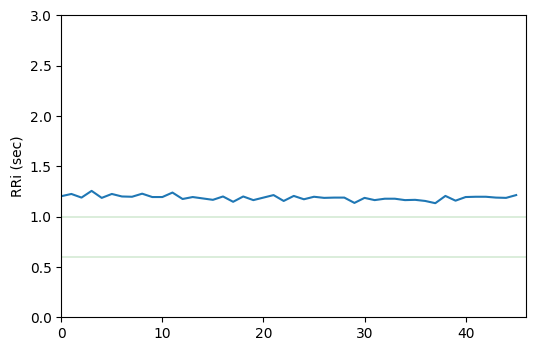

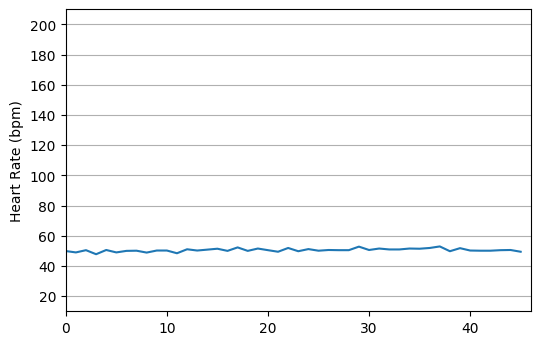

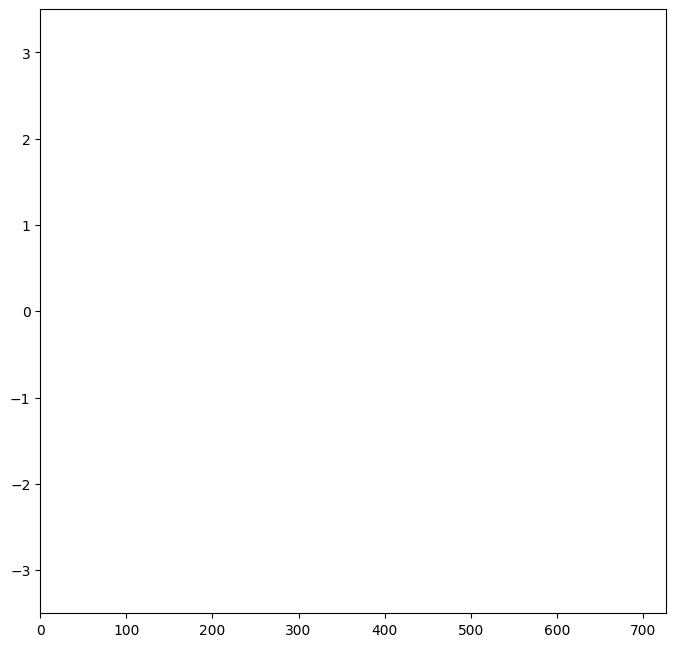

In [4]:
# Hear rate params
H_min = 30
H_low = 60
H_hig = 100
H_max = 200

beat_win_min = 60 / H_min  #seconds
#base_png_dir = '/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_png/'

# 1 select random database
randdb = ['mitdb' , 'svdb', 'incartdb']
idbs = randdb[random.randint(0,2)]#'mitdb'  # 'mitdb'  'svdb' 'incartdb'
dbs = all_db[idbs]

# 2 select random record
reclist = list(dbs.recs)
irec = reclist[random.randint(0,len(reclist)-1)] #'219'
selrec = dbs.get_record(irec)
print('selected record ' + str(selrec.name))

# 3 read record data and params
manual_gain=1/selrec.gain
srate = selrec.db.srate
selrec.load_data(g_ANT_POSTFIX)   
selrec.load_data(g_MED5_POSTFIX)
selrec.load_data(g_MED2_POSTFIX)
# 6 extract signals ==================================================================================
med2 = selrec.read_data(g_MED2_POSTFIX)
med5 = selrec.read_data(g_MED5_POSTFIX)
meds = [med2, med5]
L = len(med2)
Lsec = L / srate # total record length in seconds ~ 1800 secs

# 4 Data View Parameters
v_cutoff = beat_win_min #  = 2 sec NOTE: any beat within this interval from either side of the view is not considered a beat
v_dur = 60 #random.randint(20,30) #v_to - v_fo # sec random duration of 10 to 20 secs
v_fo = random.randint(v_cutoff,int(Lsec)-v_dur) #300 # sec

v_to = v_fo + v_dur # sec
# calculate time -> samples
fii = int(v_fo*srate) # sample
tii = int(v_to*srate) # sample
dii = tii-fii  # samples
cii = int(v_cutoff*srate)  # samples

# 5 extract annotations ==================================================================================
ant2 = selrec.read_data(g_ANT_POSTFIX)       # all annotations
ant_s = ant2[:,0].astype('int')
#ant_l = ant2[:,1]

ant2x = ant2[(ant_s>=fii) & (ant_s<tii)]    # within range annotations
ant_slx =  np.subtract(ant2x[:,0].astype('int'), [fii])
#print(ant2x)
ant_lx = ant2x[:,1]
ant_mx = mapstd(ant_lx)
ant2m = ant2x[ant_mx>-2]        # -1 ,0 .... are beat labels -1 being unmapped R peak
ant_sx = ant2m[:,0].astype('int')
ant_sy = ant2m[:,1]
ant2x_dict ={}                              # dictionary of annotation cound
for mk in range(0,len(ant_lx)):
    if ant_lx[mk] in ant2x_dict:
        ant2x_dict[ant_lx[mk]]+=1
    else:
        ant2x_dict[ant_lx[mk]]=1
print(selrec.name + ' [Duration] = '+ str(v_fo)+':'+str(v_to)+' = '+ str(v_dur) + ' sec')
print(str(ant2x_dict))



# for Pan-Tompkins QRS detector
detectors = Detectors(srate)
hrva = hrv.HRV(srate)
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================


#==================================================================================


# calculate padding on both sides
ri_f = 0
ri_t = 0
if fii<0:
    ri_f = -fii
    fii = 0
if tii>L:
    ri_t =  tii - L 
    tii=L



#med2X = np.arange(fi,ti,1/selrec.db.srate)




ff = 0 #figure
#print(' '+ str())

    
    # read r peaks from annotation
r_peaks = np.subtract(ant_sx, [fii])
r_peaks_N =  ant_slx[ant_mx==2]
#r_peaks_B =  ant_slx[ant_mx==1]
#r_peaks_A =  ant_slx[ant_mx==2]
#print (r_peaks)
    # ... otherwise the detected peaks
#r_peaks = detectors.pan_tompkins_detector(unfiltered_ecg = imed)
#r_peaks = detectors.hamilton_detector(unfiltered_ecg = imed)
#r_peaks = detectors.christov_detector(unfiltered_ecg = imed)
#r_peaks = detectors.engzee_detector(unfiltered_ecg = imed) #doesnt work for lead5 - no peaks detected
#r_peaks = detectors.swt_detector(unfiltered_ecg = imed)
#r_peaks = detectors.two_average_detector(unfiltered_ecg = imed)

r_peaks = np.array(r_peaks)
rr_samples = r_peaks[(r_peaks >= cii) & (r_peaks < dii - cii)] # cutoff peaks
rr_samples_N = r_peaks_N[(r_peaks_N >= cii) & (r_peaks_N < dii - cii)] # cutoff peaks
#calculate Rate and RR Interval array
nos_peaks = len(rr_samples)
heart_rate = hrva.HR(rr_samples)
RRi = np.zeros(nos_peaks-1,dtype = 'float')
for i in range(0,nos_peaks-1):
    RRi[i]=(rr_samples[i+1]-rr_samples[i])/srate


man_heart_rate = (nos_peaks*60)/(v_dur-2*v_cutoff)
avg_heart_rate = np.average(heart_rate)
avg_rri = np.average(RRi)
rri_hear_rate = (60/avg_rri)
final_hear_rate = (man_heart_rate+avg_heart_rate+rri_hear_rate)/3

print('Nos peaks '+ str(nos_peaks))
print('Avergae RR Interval\t'+ str(avg_rri))
print('\nManual Heart rate\t'+ str(man_heart_rate))
print('Avergae Heart rate\t'+ str(avg_heart_rate))
print('Avergae RRi Rate\t'+ str(rri_hear_rate))
print('Final Heart Rate\t'+ str(final_hear_rate))



beat_window = (60/final_hear_rate)  * 0.85
print('Beat Window\t'+ str(beat_window))

beat_window_s = int(beat_window*srate) #samples
# if odd make it even
#if beat_window_s % 2 != 0:
#    beat_window_s+=1
plt.figure(ff, dpi=100)
ff+=1
#print('RRi Array\n'+str(RRi))
plt.ylabel('RRi (sec)')
plt.ylim(0, 3) # secs
plt.xlim(0, len(RRi))
plt.plot(RRi)
plt.hlines((60/H_low),0,len(RRi),linewidth=0.2, color='green')
plt.hlines((60/H_hig),0,len(RRi),linewidth=0.2, color='green')

#Calculate heart-rates from R peak samples.
print('Nos RRis '+str(len(heart_rate)))

plt.figure(ff, dpi=100)
ff+=1
aa = plt.axes()
ax = aa.get_xaxis()
ay = aa.get_yaxis()
ay.set_major_locator(ticker.MultipleLocator(20))
#print('RRi Array\n'+str(RRi))
plt.ylabel('Heart Rate (bpm)')
plt.ylim(H_min-20, H_max+10) #bpm
plt.xlim(0, len(heart_rate))
plt.plot(heart_rate)
plt.grid(axis='y')


#plt.figure(ff, dpi=100)
#ff+=1
#aa = plt.axes()
#ax = aa.get_xaxis()
#ay = aa.get_yaxis()
#ay.set_major_locator(ticker.MultipleLocator(20))
#print('RRi Array\n'+str(RRi))
#plt.ylabel('Heart Rate (bpm)')
#plt.ylim(H_min-20, H_max+10) #bpm
#plt.xlim(0, len(heart_rate))
#plt.plot(heart_rate)
#plt.grid(axis='y')


#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


#print('Calculate heart-rates from R peak samples. '+ str(heart_rate))

#h_NN20 = hrva.NN20( rr_samples)
#print('Calculate NN20, the number of pairs of successive NNs that differ by more than 20 ms. '+ str(h_NN20))
#Calculate NN20, the number of pairs of successive
#NNs that differ by more than 20 ms.

#h_NN50 = hrva.NN50( rr_samples)
#print('Calculate NN50, the number of pairs of successive NNs that differ by more than 50 ms. '+ str(h_NN50))
#Calculate NN50, the number of pairs of successive
#NNs that differ by more than 50 ms.

#h_RMSD = hrva.RMSSD( rr_samples, normalise=False)
#print('Calculate RMSSD (root mean square of successive differences). '+ str(h_RMSD))
#Calculate RMSSD (root mean square of successive differences).

#h_SD = hrva.SDANN( rr_samples, average_period=5.0, normalise=False)
#print('Calculate SDANN, the standard deviation of the average '+ str(h_SD))
#Calculate SDANN, the standard deviation of the average
#RR intervals calculated over short periods.

h_SDNN = hrva.SDNN( rr_samples, normalise=False)
print('Calculate SDNN, the standard deviation of NN intervals. '+ str(h_SDNN))
#Calculate SDNN, the standard deviation of NN intervals.


h_SDSD = hrva.SDSD( rr_samples)
print('Calculate the standard deviation of the successive differences between adjacent NNs. '+ str(h_SDSD))
#Calculate SDSD (standard deviation of successive differences),
#the standard deviation of the successive differences between adjacent NNs.

h_fs = hrva.fAnalysis( rr_samples)
print('returns the LF/HF-ratio. '+ str(h_fs))
print(hrva.lf)
print(hrva.hf)
#Frequency analysis to calc self.lf, self.hf,
#returns the LF/HF-ratio.

#h_pNN20 = hrva.pNN20( rr_samples)
#print('Calculate pNN20, the proportion of NN20 divided by total number of NNs. '+ str(h_pNN20))
#Calculate pNN20, the proportion of NN20 divided by total number of NNs.

#h_pNN50 = hrva.pNN50( rr_samples)
#print('Calculate pNN50, the proportion of NN50 divided by total number of NNs. '+ str(h_pNN50))
#Calculate pNN50, the proportion of NN50 divided by total number of NNs.
    # perpare figure - MEDIAN BEAT ======================================


stats_dict={}
stats_dict['mean'] = stats.mean(RRi)
#stats_dict['geometric_mean'] = stats.geometric_mean(RRi)
#stats_dict['harmonic_mean'] = stats.harmonic_mean(RRi)
stats_dict['median'] = stats.median(RRi)
stats_dict['median_low'] = stats.median_low(RRi)
stats_dict['median_high'] = stats.median_high(RRi)
stats_dict['median_grouped'] = stats.median_grouped(RRi)

try_mode = 0
try:
  try_mode = stats.mode(RRi)
except:
  print("Cant find mode...")
else:
  stats_dict['mode'] = try_mode
  print("found mode = "+ str(try_mode))

stats_dict['pstdev'] = stats.pstdev(RRi)
stats_dict['pvariance'] = stats.pvariance(RRi)
stats_dict['stdev'] = stats.stdev(RRi,stats_dict['median'])
stats_dict['variance'] = stats.variance(RRi,stats_dict['median'])
#print('Stats')
print_dict('stats',stats_dict, '\t')


for mx in range (0,len(meds)):
    print('========= LEAD '+ str(mx))
    imed = meds[mx][fii:tii] # the signal
    imed = np.multiply(imed, [manual_gain]) # normalized signal    
    #beat_sides = int((beat_window_s)*2)  # surely divisible
    # for each rr_samples take beat_sides from either side
    plt.figure(ff,  figsize=( 4*(beat_window_s *2 +1)/srate, 8 )  ,dpi=100)
    ff+=1
    plt.ylim( -3.5, 3.5 )  # mv
    plt.xlim( 0 , beat_window_s *2 +1 )   # 

    beat_dict = np.zeros((0,beat_window_s*2),dtype = 'float')
    #print(beat_window_s*2)
    for rrs in range(0,len(rr_samples_N)):
        peak_at = rr_samples_N[rrs]
        rfo = peak_at-beat_window_s
        rto = peak_at+beat_window_s
        beat_i = imed[rfo:rto]
        #print(len(beat_i))
        plt.plot(beat_i, label = str(rrs), linewidth=0.2, color='black')
        beat_dict = np.vstack((beat_dict,beat_i))
    print('Beat Dict: '+ str(beat_dict.shape))
    print(beat_dict) #<---------------------------------------------------------------Got all beats here - cluster them
    row = beat_dict.shape[0]  # nos of rows (data points / vectors)
    col = beat_dict.shape[1]  # nos of coloumns (dimensions)

    med_beat = np.zeros(col)
    mean_beat = np.zeros(col)
    for coli in range(0,col): # for all coulumns find median
        med_beat[coli] = stats.median(beat_dict[:,coli])
        mean_beat[coli] = stats.mean(beat_dict[:,coli])
    plt.plot(med_beat)
    plt.plot(mean_beat)


    # perpare figure ======================================
    plt.figure(ff, figsize=( dii/srate, 8 )  ,dpi=50)
    ff+=1
    plt.ylim( -3.5, 3.5 )  # mv
    plt.xlim( 0 , dii  )   # 
    aa = plt.axes()
    ax = aa.get_xaxis()
    ay = aa.get_yaxis()
    #ax.set_major_locator(ticker.MultipleLocator(srate))
    ay.set_visible(False)
    plt.grid(axis='x')
    plt.xticks(ant_slx,ant_lx)
    plt.plot(imed,linewidth='0.2', color='black')
    plt.plot( np.arange(0, cii, 1), imed[0:cii],linewidth='0.5', color='red')
    plt.plot( np.arange(dii-cii, dii, 1), imed[dii-cii:dii]  ,linewidth='0.5', color='red')
    plt.scatter(rr_samples, np.ones(len(rr_samples)),color='red',marker='x')
    #plt.scatter(max_peaks, np.zeros(len(max_peaks)),color='blue',marker='.')
    


# TO DO :: NEXT find DISSIMILARITY MEASURE and CLUSTER beats locally within a stable range of RRi

# in the whole record find parts where RRIntervals remain constant and treat those as representing on cluster - cluster them

# Old Code

In [0]:
d = datetime.datetime.now( )
print(datetime.datetime.now( ).strftime("%d%m%H%M%S"))

time_period = 12 
time_delta = [-1,1]  #[min,max] in secs
time_total = 1800 #secs
sel_per_rec = 5*60 #secs = 300

# constant----------------------------------------
time_resol = 0.04
time_safe = 2
time_safe_resol = time_safe / time_resol
time_step = int(time_period/time_resol)


# --- data plotting for input data
x_scale = 0.04 * 25
y_scale = 0.04 * 10
m_scale = 1
fwid = ((ti-fi)/my_db.srate) * x_scale * m_scale
fhig = 6 * y_scale * m_scale
lysize = (fwid,fhig*1) #secods
# constant----------------------------------------

2502204742


In [0]:
# LOOPING TO SAVE
allfig=0

win_sel = int(sel_per_rec/time_period) # = 30
win_total = int(time_total/time_period) # = 180
print('time_period = '+str(time_period) + ' sec')
print('time_delta = '+str(time_delta) + ' sec')
print('sel_per_rec = '+str(sel_per_rec) + ' sec')
print('selection: '+str(win_sel) + ' of '+str(win_total) + ' views per record')
#save_these = []

megadb = np.zeros((0,4),dtype='str') # [db rec fi ti]
for idbs in ['mitdb']:#all_db.keys():
    #idbs = 'svdb'  # 'mitdb'  'svdb' 'incartdb'

    dbs = all_db[idbs]
    L = 1800 * dbs.srate                          # max within 30 mins
    for irec in dbs.recs:
        #irec = '868'
        selrec = dbs.get_record(irec)
        sel_ind = set([]) # empty set
        while len(sel_ind)<win_sel:
            sel_ind.add(time_period * random.randint( 1, win_total-1-1 ) + random.randint(time_delta[0],time_delta[1]) )
        
        time_start = np.array(  list(sel_ind)   ) 
        
        time_period_samps = time_period * dbs.srate
        time_start_samps = np.multiply(time_start,[dbs.srate])
        print(str(allfig)+'\t'+ selrec.name)
        for tstart in time_start_samps:
            fi = (tstart)
            ti = (tstart+time_period_samps)
            #save_prefix = selrec.name+'_'+str(fi)+'_'+str(ti)       # name = dbname_rec_fi_ti
            if fi<0 or ti>L:
                print ('Beyond Limits : can not form this view')
                continue
            cvinfo = np.array( [selrec.db.name,selrec.rec,str(fi),str(ti)  ] )
            #print('\t'+str(cvinfo))
            megadb= np.vstack( (megadb,cvinfo )  ) # [db rec fi ti]
            allfig+=1

print('saving...'+ str(len(megadb))+ ' views')
save_prefix = datetime.datetime.now( ).strftime("%d%m%H%M%S")           
np.save(os.path.join(global_datadir,save_prefix+'_vdb.npy'), megadb)
print(save_prefix)

time_period = 12 sec
time_delta = [-1, 1] sec
sel_per_rec = 300 sec
selection: 25 of 150 views per record
0	mitdb_118
25	mitdb_228
50	mitdb_122
75	mitdb_212
100	mitdb_113
125	mitdb_234
150	mitdb_124
175	mitdb_201
200	mitdb_205
225	mitdb_220
250	mitdb_108
275	mitdb_222
300	mitdb_121
325	mitdb_200
350	mitdb_210
375	mitdb_203
400	mitdb_106
425	mitdb_221
450	mitdb_208
475	mitdb_123
500	mitdb_233
525	mitdb_115
550	mitdb_111
575	mitdb_231
600	mitdb_209
625	mitdb_114
650	mitdb_214
675	mitdb_217
700	mitdb_107
725	mitdb_109
750	mitdb_119
775	mitdb_102
800	mitdb_104
825	mitdb_202
850	mitdb_232
875	mitdb_116
900	mitdb_215
925	mitdb_101
950	mitdb_103
975	mitdb_213
1000	mitdb_207
1025	mitdb_230
1050	mitdb_112
1075	mitdb_219
1100	mitdb_100
1125	mitdb_105
1150	mitdb_223
1175	mitdb_117
saving...1200 views
2502161737


In [0]:
flist = os.listdir(global_datadir)
for i in range(0,len(flist)):
    print(str(i)+'\t'+ str(flist[i]))

In [0]:
#fli = flist[random.randint(0,len(flist)-1)]                                      # select databse file [ 1 ]
fli = flist[0]                                      # select databse file [ 1 ]
argsa = np.load(os.path.join(global_datadir,fli))
print(str(fli)+ ' - loaded ' + str(len(argsa))+ ' views ')

2502161737_vdb.npy - loaded 1200 views 


  Selected [632] ['mitdb' '114' '151560' '155880']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(3600, -2, '|')

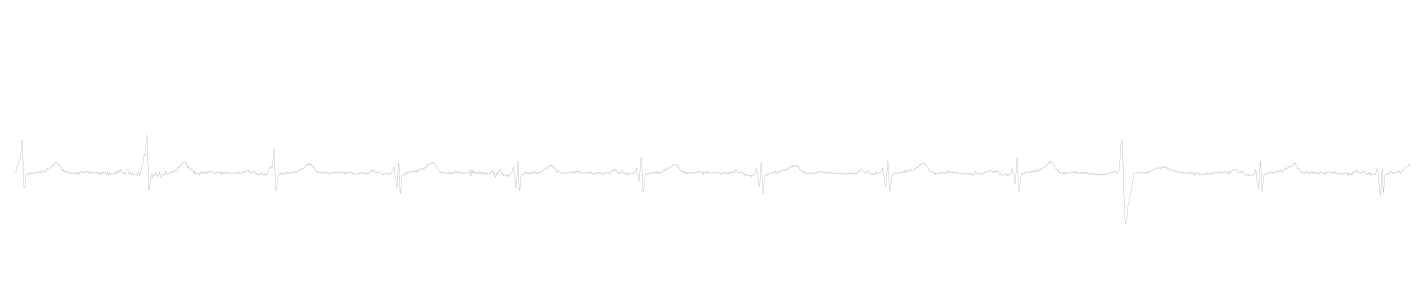

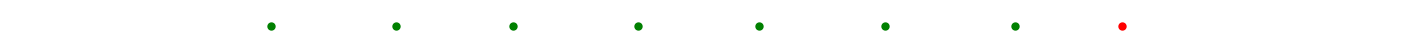

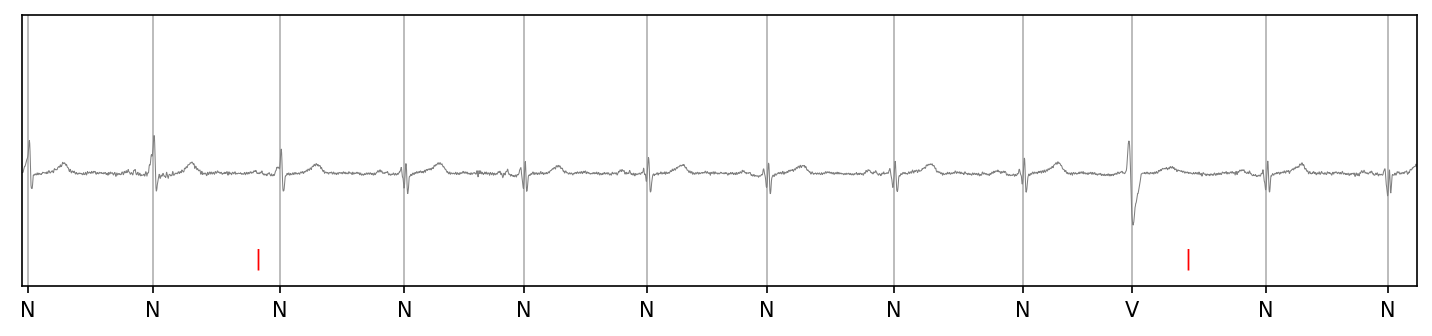

In [0]:


rdi = random.randint(0,len(argsa)-1)
args=argsa[rdi]                                       # select view 
print( '  Selected ['+ str(rdi) +'] '+ str(args))


dbi = args[0]
reci = args[1]
fi = int(args[2])
ti = int(args[3])
my_db = all_db[dbi]
my_rec = my_db.get_record(reci)
manual_gain=1/my_rec.gain
save_prefix = dbi+'_'+reci+'_'+str(fi)+'_'+str(ti)    # name = dbname_rec_fi_ti


# load signal ======================================================================================
signalmed2 = np.multiply(my_rec.load_data(g_MED_POSTFIX)[fi:ti],[manual_gain])
#signalraw2 = np.multiply(my_rec.load_data(g_RAW_POSTFIX)[fi:ti],[manual_gain])
plt.figure(0,figsize=lysize, frameon=False, dpi=150)
plt.ylim((-2.5,3.5))
plt.xlim((0,ti-fi))
plt.axis('off')
plt.plot(signalmed2,color='grey',linewidth=0.1)
plt.savefig(os.path.join(global_datadir,save_prefix+'_x.png'),bbox_inches='tight')

# load all annotations for selected record ======================================================================================
vinfo = my_rec.load_data(g_ANT_POSTFIX)
# get annotations within limits
vinfo_s = vinfo[:,0].astype('int') # samples as integers
vinfo_lim = vinfo[ (vinfo_s>=fi ) & (vinfo_s<ti) ]
# get mapping : (>=0 are mapped R peak labes, -1 is unmapped beat label, -2 is unmapped non beat label)
vinfo_lim_s =  np.subtract(vinfo_lim[:,0].astype('int'),[fi])  # within limits, samples as integers
vinfo_lim_l = vinfo_lim[:,1]                 # within limits, labels
vinfo_lim_li = mapstd(vinfo_lim_l)           # within limits, integer labels
# convert lim_s to time stamps in seconds
vinfo_lim_st = np.multiply(vinfo_lim_s,[1/(time_resol*my_db.srate)]).astype('int')

lysizey = (fwid,0.2)
plt.figure(1,figsize=lysizey, frameon=False, dpi=150)
plt.ylim((-1,1))
plt.xlim((0,time_step))
#plt.axes().get_yaxis().set_visible(False)
plt.axis('off')
# continuous labels - DATA LABELS-------------------------------------------------------


#l_cont = np.subtract(np.zeros(time_step),[1])
# for each timestamp in vinfo_lim_st, l_cont[timestamp] = vinfo_lim_li ]
#plt.scatter(vinfo_lim_st,vinfo_lim_l)

#for i in range(0, len(vinfo_lim_st)):
#    ts = vinfo_lim_st[i]
#    tl =  vinfo_lim_li[i]
#    if ts >= time_safe_resol and ts < time_step- time_safe_resol:##

#        if tl < 0:
#            l_cont[ts] = -1  # tl can be -2, -1, >=0
#            
#        else:
#            l_cont[ts] = tl  # tl can be -2, -1, >=0
#            #plt.annotate(vinfo_lim_l[i], xy=(ts,0) )



#plt.plot(l_cont,linewidth=0.2,color='grey')
vx = vinfo_lim_st[(vinfo_lim_st > time_safe_resol) & (vinfo_lim_st < time_step- time_safe_resol)]
vy = vinfo_lim_li[(vinfo_lim_st > time_safe_resol) & (vinfo_lim_st < time_step- time_safe_resol)]
for i in range(0, g_COUNT):
    
    c_cont = np.where(vy==i)[0]
    plt.scatter(  vx[c_cont], np.zeros(len(vy[c_cont])), color = g_COLORS[i] ,marker='.')
# continuous labels - DATA LABELS------------------------------------------------------- np.arange(0,time_step,1)
plt.savefig(os.path.join(global_datadir,save_prefix+'_y.png'),bbox_inches='tight')


# l_cont, signalmed2
#np.save(os.path.join(global_datadir,save_prefix+'_y.npy'),l_cont )
#np.save(os.path.join(global_datadir,save_prefix+'_y.npy'),signalmed2 )

plt.figure(2,figsize=lysize, frameon=False, dpi=150)
plt.ylim((-2.5,3.5))
plt.xlim((0,ti-fi))
#plt.axis('off')
plt.axes().get_yaxis().set_visible(False)
plt.grid(axis='x')
plt.plot(signalmed2,color='grey',linewidth=0.5)
plt.xticks(vinfo_lim_s,vinfo_lim_l)
plt.annotate( '|', xy=(time_safe*my_db.srate,-2),color= 'red')
plt.annotate( '|', xy=((time_period-time_safe)*my_db.srate,-2),color= 'red')



#plt.axes().get_yaxis().set_visible(False)
#aa = plt.axes()
#ax = aa.get_xaxis()
#ay = aa.get_yaxis()
#ax.set_major_locator(ticker.MultipleLocator((my_rec.db.srate)))
#ay.set_major_locator(ticker.MultipleLocator((1/1)))
#plt.grid(axis='x',color='green')

#plt.plot(signalraw2,color='red',linewidth=0.1)
#plt.plot(np.subtract(signalmed2,signalraw2),color='red',linewidth=0.1)
#plt.xticks(vinfo_lim_s,vinfo_lim_l)



#vinfo_ll = mapstd(vinfo_l)

#for i in range(0,len(vinfo_s1)):
#    vsi = vinfo_s1[i]
    # if vsi is within time_safe seconds from either side of the view then take it
    #if vsi < time_safe_samps or vsi > (ti-fi) - time_safe_samps:
    #    continue
    #il = vinfo_l[i]
    #icol = 'green'
    #if il!='N':
    #    icol = 'red'
#    plt.annotate( vinfo_l1[i], xy=(vinfo_s1[i],-2),color= 'grey')
    #plt.annotate( vinfo_ll[i], xy=(vinfo_s[i],-2.5),color= 'black')
#for jx in range(0,g_COUNT):
#    vind = np.where(vinfo_ll==jx)[0]
#    plt.scatter(vinfo_s[vind], np.multiply(vinfo_ll[vind],[0]),color=g_COLORS[jx],marker = '.')

# build output array
#resol = 0.04 #sec

#print('tt')
#aa = plt.axes()
#ax = aa.get_xaxis()
#ay = aa.get_yaxis()
#ax.set_major_locator(ticker.MultipleLocator((my_rec.db.srate)))

#print(vinfo_s)
#yind = np.multiply(vinfo_s,[1/(resol*my_db.srate)]).astype('int')
#rstep = int(time_period/resol)
#ylab = np.zeros(rstep)
#print(yind)
#ylab[yind] = 1

#print(l_cont)
#plt.scatter(yind,vinfo_l)
#for jx in range(0,g_COUNT):
#    vind = np.where(vinfo_ll==jx)[0]
#   plt.scatter(yind[vind], np.multiply(vinfo_ll[vind],[0]),color=g_COLORS[jx],marker = '.')
#plt.title(save_prefix)


In [0]:
flist = os.listdir(global_datadir)
for i in range(0,len(flist)):
    print(str(i)+'\t'+ str(flist[i]))

(301, 1425, 3)
(52, 1425, 3)


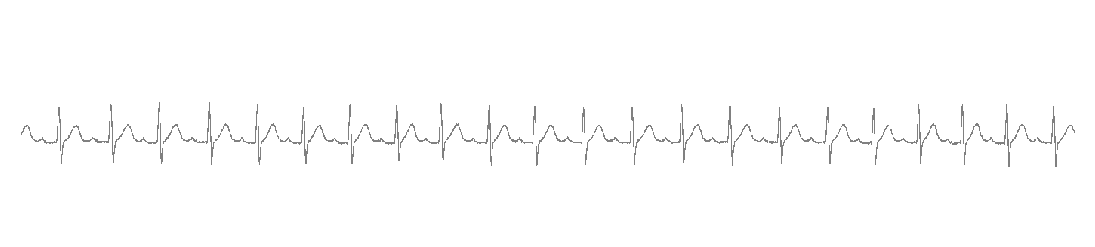

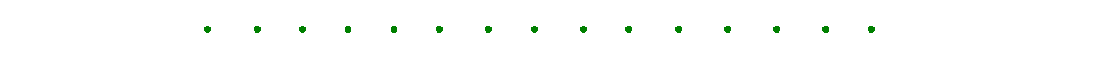

In [0]:
# l_cont, signalmed2
import cv2
#import cv2_imshow
save_prefix='mitdb_215_549000_553320_'
impathx = os.path.join(global_datadir,save_prefix+'x.png')
impathy = os.path.join(global_datadir,save_prefix+'y.png')
imgx = cv2.imread( impathx)
imgy = cv2.imread( impathy)
#img = cv2.imread(impath,0)
print(imgx.shape)
print(imgy.shape)
# The underlying representation is a numpy array!

rt = 0.01
plt.figure(0, figsize=(imgx.shape[1]*rt,imgx.shape[0]*rt), dpi = 100)
#plt.axes().get_yaxis().set_visible(False)
plt.axis('off')
#plt.imshow(imgx )
#print(type(imgx))
plt.imshow(imgx)
plt.show()

plt.figure(0, figsize=(imgy.shape[1]*rt,imgy.shape[0]*rt), dpi = 100)
plt.axis('off')
#plt.axes().get_yaxis().set_visible(False)
#plt.imshow(imgy)
#print(type(imgy))
plt.imshow(imgy)
plt.show()
#Y = np.load(os.path.join(global_datadir,save_prefix+'_y.npy'))
#cv2.imshow(img )
#plt.plot(X)
#plt.figure(1, figsize=lysize, dpi = 150)
#plt.xlim(0,time_step )
#plt.plot(Y)


In [0]:
img = cv2.imread('./dt.jpg', 0)

# The underlying representation is a numpy array!
print(type(img))

plt.imshow(img)
plt.show()

img = cv2.imread('./dt.jpg')

plt.imshow(img)
plt.show()

ERROR: Could not find a version that satisfies the requirement cv2_imshow (from versions: none)
ERROR: No matching distribution found for cv2_imshow
